In [4]:
!pip install -q mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

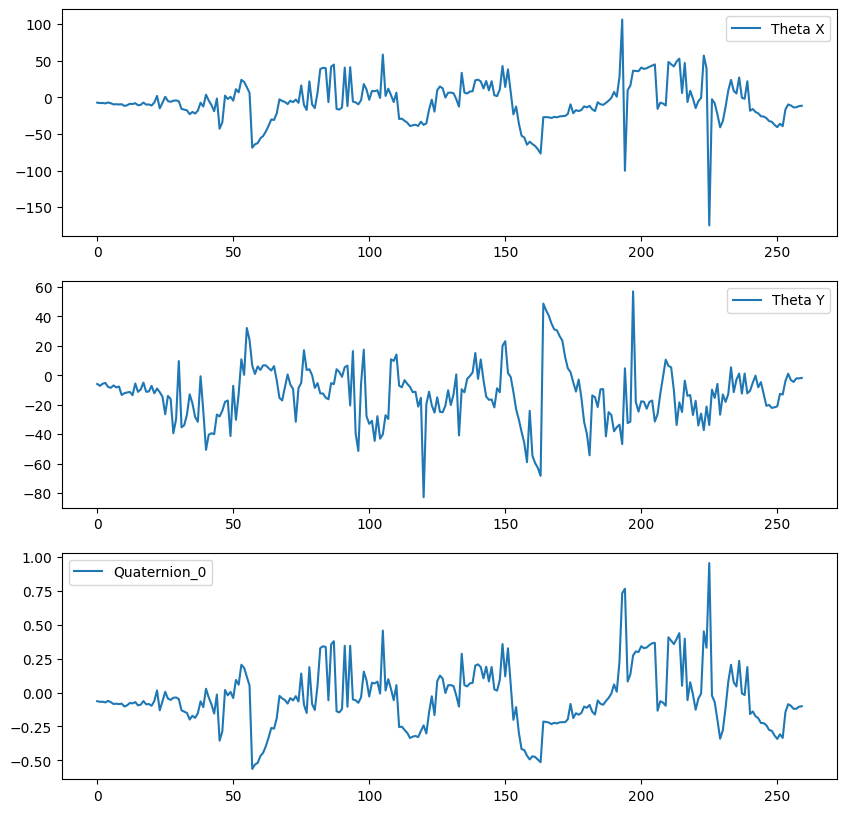

In [11]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, model_complexity=2, enable_segmentation=False, smooth_landmarks=True)

# Load videos
cap_lateral = cv2.VideoCapture('lateral.mp4')
cap_front = cv2.VideoCapture('frontal.mp4')

# Get the number of frames for each video
num_frames_lateral = int(cap_lateral.get(cv2.CAP_PROP_FRAME_COUNT))
num_frames_front = int(cap_front.get(cv2.CAP_PROP_FRAME_COUNT))

# Determine the minimum number of frames
min_frames = min(num_frames_lateral, num_frames_front)

# Check if videos are opened successfully
if not cap_lateral.isOpened() or not cap_front.isOpened():
    print("Error opening video streams or files")

# Prepare to collect data
theta_x = []
theta_y = []
quaternion = []

# Process videos frame by frame
for _ in range(min_frames):
    success_lateral, frame_lateral = cap_lateral.read()
    success_front, frame_front = cap_front.read()

    if not success_lateral or not success_front:
        break

    # Convert the BGR images to RGB
    rgb_frame_lateral = cv2.cvtColor(frame_lateral, cv2.COLOR_BGR2RGB)
    rgb_frame_front = cv2.cvtColor(frame_front, cv2.COLOR_BGR2RGB)

    # Process the frames with MediaPipe Pose
    results_lateral = pose.process(rgb_frame_lateral)
    results_front = pose.process(rgb_frame_front)

    # Extract landmarks for both views
    try:
        landmarks_lateral = results_lateral.pose_landmarks.landmark
        landmarks_front = results_front.pose_landmarks.landmark

        # Compute angles and rotation matrix for the right leg
        knee_lateral = np.array([landmarks_lateral[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,
                                 landmarks_lateral[mp_pose.PoseLandmark.RIGHT_KNEE.value].y])
        ankle_lateral = np.array([landmarks_lateral[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,
                                  landmarks_lateral[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y])

        knee_front = np.array([landmarks_front[mp_pose.PoseLandmark.LEFT_KNEE.value].x,
                                landmarks_front[mp_pose.PoseLandmark.LEFT_KNEE.value].y])
        ankle_front = np.array([landmarks_front[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,
                                 landmarks_front[mp_pose.PoseLandmark.LEFT_ANKLE.value].y])

        # Calculate θx and θy using both lateral and front views
        theta_x_value = np.arctan2(ankle_lateral[0] - knee_lateral[0], ankle_lateral[1] - knee_lateral[1])
        theta_y_value = np.arctan2(ankle_front[0] - knee_front[0], ankle_front[1] - knee_front[1])

        # Append to lists
        theta_x.append(np.degrees(theta_x_value))
        theta_y.append(np.degrees(theta_y_value))

        # Form the rotation matrix
        rotation_matrix = R.from_euler('xy', [theta_x_value, theta_y_value]).as_matrix()

        # Compute the vector e (axis of rotation) and quaternion
        axis_of_rotation = np.cross(knee_lateral - ankle_lateral, knee_front - ankle_front)
        axis_of_rotation = axis_of_rotation / np.linalg.norm(axis_of_rotation)
        quaternion_value = R.from_matrix(rotation_matrix).as_quat()

        # Calculate quaternion magnitude
        quaternion.append(quaternion_value[0])

    except:
        pass

# Release
cap_lateral.release()
cap_front.release()

# Plots
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(theta_x, label='Theta X')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(theta_y, label='Theta Y')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(quaternion, label='Quaternion_0')
plt.legend()

plt.show()


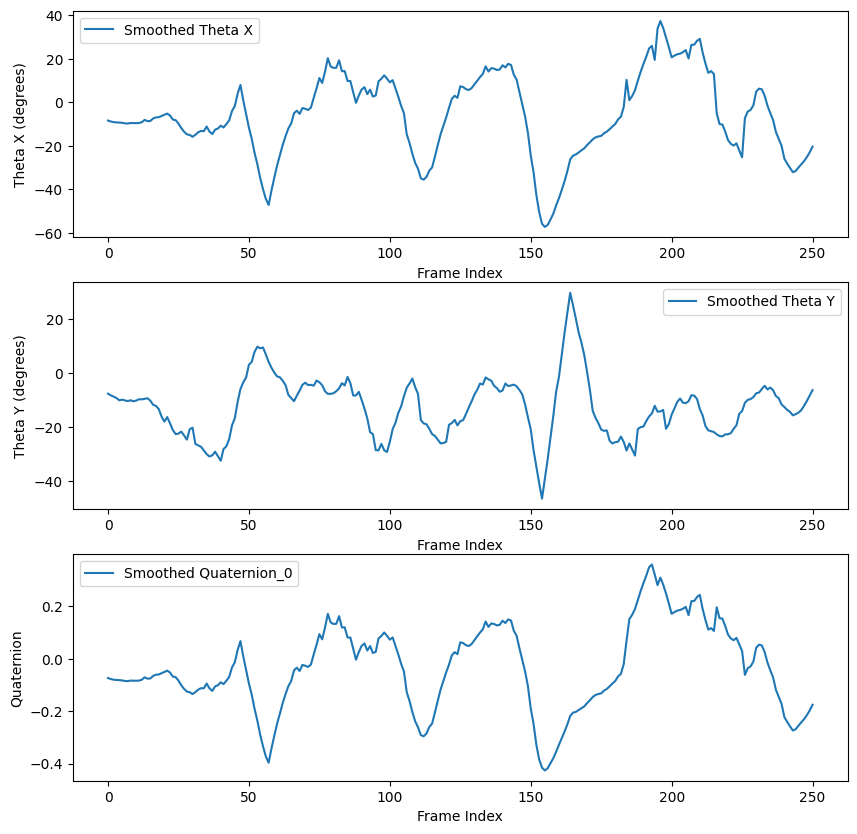

In [12]:
window_size = 10
theta_x_smoothed = np.convolve(theta_x, np.ones(window_size) / window_size, mode='valid')
theta_y_smoothed = np.convolve(theta_y, np.ones(window_size) / window_size, mode='valid')
quaternion_smoothed = np.convolve(quaternion, np.ones(window_size) / window_size, mode='valid')

# Plot the smoothed data
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
plt.plot(theta_x_smoothed, label='Smoothed Theta X')
plt.xlabel('Frame Index')
plt.ylabel('Theta X (degrees)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(theta_y_smoothed, label='Smoothed Theta Y')
plt.xlabel('Frame Index')
plt.ylabel('Theta Y (degrees)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(quaternion_smoothed, label='Smoothed Quaternion_0')
plt.xlabel('Frame Index')
plt.ylabel('Quaternion')
plt.legend()

plt.show()

In [1]:
import cv2
import mediapipe as mp

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, min_detection_confidence=0.5)

# Open the video
cap = cv2.VideoCapture('frontal.mp4')

# Set up the video writer to save output
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_video.mp4', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    break

  # Convert the BGR image to RGB
  rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Process the frame with MediaPipe Pose
  results = pose.process(rgb_frame)

# Draw the pose landmarks
  mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

# Write the frame to the output video
  out.write(frame)

  if cv2.waitKey(5) & 0xFF == 27:
    break

# Release the video capture and writer
cap.release()
out.release()

# Close the display window
cv2.destroyAllWindows()

ModuleNotFoundError: No module named 'mediapipe'